# FruitDetect: Machine Learning for Fruit Identification

### Project Description

The "FruitDetect: Machine Learning for Fruit Identification" project is an attempt to harnesses the capabilities of neural networks to tackle the complex task of classifying 131 distinct fruit varieties based on their images.  
Identifying and categorizing fruits manually can be a daunting challenge due to the immense diversity in shape, size, color, and texture across different fruit types.  
The neural networks employed in this project possess the capability to learn intricate patterns and features from the input fruit images, enabling them to make highly accurate predictions regarding the fruit's class. Through the power of convolutional neural networks (CNNs) and deep learning techniques, we have fine-tuned our models to recognize not only the most common fruits but also rare and exotic varieties.


In [1]:
# Check for GPU
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-49193249-6474-88e0-de8c-7c8f312308e7)


## Defining Problem

**Objective**  
To Classify 131 different fruit images using ANNs, CNNs as well as Transfer Learning  

**Data**  
The data used for this project is available in [kaggle](https://www.kaggle.com/datasets/moltean/fruits)  
We will import the dataset from kaggle using he API  
The dataset contains:  
* *__Train__*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for training purpose.
* *__Test__*: This folder contains folders labelled as fruit's/vegetable's name. These subfolders contain images of the respective fruit/vegetable. This folder will be used for testing purpose.

In [ ]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d moltean/fruits

 99% 1.27G/1.28G [00:08<00:00, 181MB/s]
100% 1.28G/1.28G [00:08<00:00, 169MB/s]


In [2]:
# Importing necessary libraries

import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator,array_to_img
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import zipfile
import random
from PIL import Image
import numpy as np

In [ ]:
# Setting the random seed so that everytime our parameters remain fixed
tf.random.set_seed(123)

In [ ]:
# Unzipping the zip file
zip=zipfile.ZipFile('/content/fruits.zip','r')
zip.extractall()
zip.close()

In [ ]:
# Setting up necessary variables
train_path='/content/fruits-360_dataset/fruits-360/Training'
test_path='/content/fruits-360_dataset/fruits-360/Test'

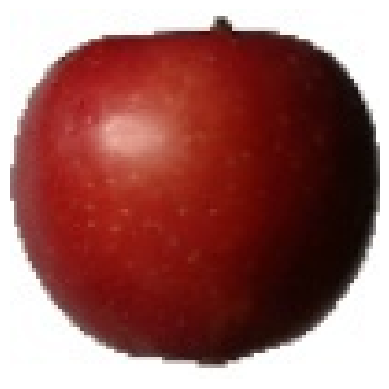

In [ ]:
# Checking images from train dataset
image_path = '/content/fruits-360_dataset/fruits-360/Training/Apple Braeburn/100_100.jpg'
img = Image.open(image_path)
plt.imshow(img)
plt.axis('off')
plt.show()

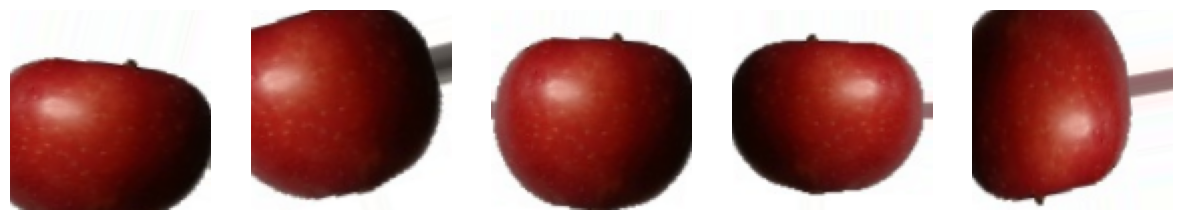

In [ ]:
# getting the data from directory and performing data augmentation only on training data
train_datagen=ImageDataGenerator(
    rescale=1./255., # rescaling the images
    rotation_range=40, # rotating the image by 40 degrees
    width_shift_range=0.2, # shifting the image +-(20%) of original width
    height_shift_range=0.2, # shifting the image +-(20%) of original height
    shear_range=0.2, # shearing the image by 20% of image
    zoom_range=0.2, # zooming the image 20%
    validation_split=0.2,# splitting train data into train and validation set with 8:2 ratio
    horizontal_flip=True, # horizontaly flipping the image
    vertical_flip=True # vertically flipping the image
)
img = np.array(Image.open(image_path))
img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels)

# Generate augmented images and display them
augmentations = 5  # Number of augmented images to generate
fig, axs = plt.subplots(1, augmentations, figsize=(15, 5))

for i, augmented_image in enumerate(train_datagen.flow(img, batch_size=1)):
    axs[i].imshow(array_to_img(augmented_image[0]))
    axs[i].axis('off')
    if i == augmentations - 1:
        break

plt.show()

In [ ]:
# we do not need to augment the test data just rescale the data
test_datagen=ImageDataGenerator(rescale=1./255.)

In [ ]:
# there are 6 classes and image size is 100X100
# creating three different data i.e. Train_data, Valid_data, Test_data
train_data = train_datagen.flow_from_directory(
    train_path,
    batch_size = 50,
    class_mode = 'categorical',
    target_size = (100,100),
    subset='training'
)
val_data = train_datagen.flow_from_directory(
    train_path,
    batch_size = 50,
    class_mode = 'categorical',
    target_size = (100,100),
    subset='validation'
)
test_data = test_datagen.flow_from_directory(
    test_path,
    batch_size = 50,
    class_mode = 'categorical',
    target_size = (100,100)
)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


Model 1:
1. **Layers:** 2 dense layers
2. **Optimizers:** Adam
3. **Loss:** Categorical CrossEntropy
4. **Epochs:** 10
5. **Validation Data:** Available

In [ ]:
# Create the model

input_shape=(100,100,3)

model1=tf.keras.Sequential([
    layers.Flatten(input_shape=input_shape),
    layers.Dense(3,activation='relu'),
    layers.Dense(131,activation='softmax')
],name='Model_1')


# compile model

model1.compile(optimizer = Adam(learning_rate=0.01),
              loss = 'categorical_crossentropy',
              metrics = [CategoricalAccuracy(), Precision(), Recall()])
# Get the summary
model1.summary()

# Fit the model
history=model1.fit(
    train_data,
    epochs=10,
    validation_data=val_data
)

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 30000)             0         
                                                                 
 dense_11 (Dense)            (None, 3)                 90003     
                                                                 
 dense_12 (Dense)            (None, 131)               524       
                                                                 
Total params: 90,527
Trainable params: 90,527
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
1084/1084 [==============================] - 239s 219ms/step - loss: 4.8802 - categorical_accuracy: 0.0144 - precision_5: 0.0213 - recall_5: 1.8454e-05 - val_loss: 4.8585 - val_categorical_accuracy: 0.0145 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00
Epoch 2/10
1084/1084 [=======================

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

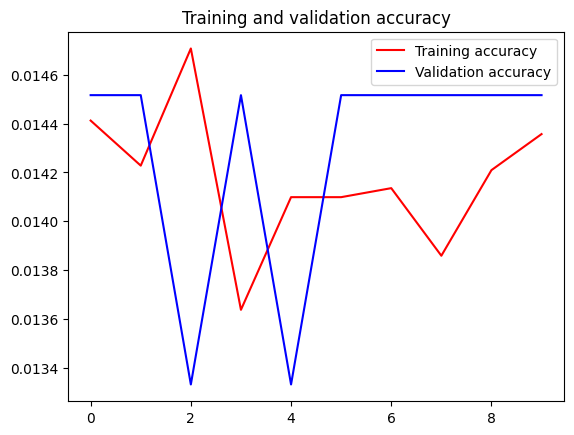

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

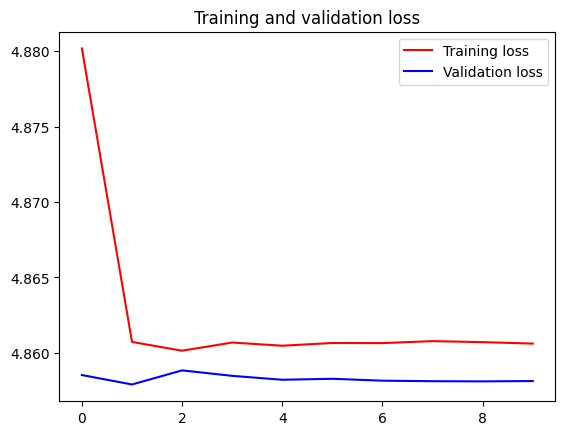

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss_1, accuracy_1, precision_1, recall_1 = model1.evaluate(test_data)
print('Loss of Model1 on test data: ',loss_1)
print('Accuracy of Model1 on test data: ',accuracy_1)
print('Precision of Model1 on test data: ',precision_1)
print('Recall of Model1 on test data: ',recall_1)

454/454 [==============================] - 13s 29ms/step - loss: 4.8586 - categorical_accuracy: 0.0145 - precision_5: 0.0000e+00 - recall_5: 0.0000e+00
Loss of Model1 on test data:  4.858613967895508
Accuracy of Model1 on test data:  0.014456981793045998
Precision of Model1 on test data:  0.0
Recall of Model1 on test data:  0.0


Model 2:
1. **Layers:** Conv2d and MaxPooling (ReLU Activation)
2. **Optimizers:** Adam
3. **Loss:** Categorical CrossEntropy
4. **Epochs:** 5
5. **Validation Data:** Available

In [ ]:
# Create the model

input_shape=(100,100,3)

model2=tf.keras.Sequential([
    layers.Conv2D(filters=10,
                  kernel_size=3,
                  activation="relu",
                  input_shape=input_shape),
    layers.MaxPool2D(pool_size=2,
                     padding="valid"),
    tf.keras.layers.Conv2D(5,1,activation="relu"),
    layers.Flatten(),
    layers.Dense(3,activation='relu'),
    layers.Dense(131,activation='softmax')
],name='Model_2')


# compile model

model2.compile(optimizer = Adam(learning_rate=0.001),
              loss = 'categorical_crossentropy',
              metrics = [CategoricalAccuracy(), Precision(), Recall()])
# Get the summary
model2.summary()

# Fit the model
history=model2.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 98, 98, 10)        280       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 49, 49, 10)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 49, 49, 5)         55        
                                                                 
 flatten_8 (Flatten)         (None, 12005)             0         
                                                                 
 dense_17 (Dense)            (None, 3)                 36018     
                                                                 
 dense_18 (Dense)            (None, 131)               524       
                                                           

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

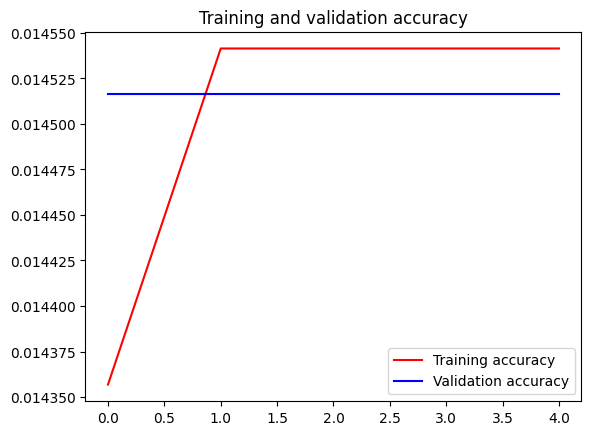

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

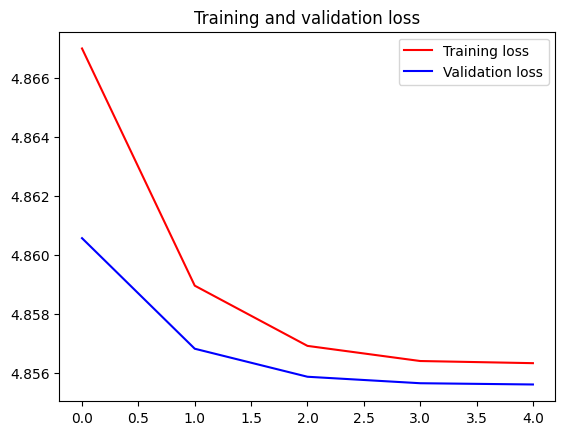

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
loss_2, accuracy_2, precision_2, recall_2 = model2.evaluate(test_data)

454/454 [==============================] - 16s 36ms/step - loss: 4.8561 - categorical_accuracy: 0.0145 - precision_8: 0.0000e+00 - recall_8: 0.0000e+00


In [ ]:
print('Loss of Model2 on test data: ',loss_2)
print('Accuracy of Model2 on test data: ',accuracy_2)
print('Precision of Model2 on test data: ',precision_2)
print('Recall of Model2 on test data: ',recall_2)

Loss of Model2 on test data:  4.856095314025879
Accuracy of Model2 on test data:  0.014456981793045998
Precision of Model2 on test data:  0.0
Recall of Model2 on test data:  0.0


##TRANSFER LEARNING

### During this part of transfer learning we will not fine tune our model to our dataset rather we will use pre-trained weights only for our CNN and only 1 dense layer with softmax activation to classify our images

#### Transfer learning model 1 InceptionNet

The Inception model, officially known as GoogleNet or InceptionNet, is a deep convolutional neural network (CNN) architecture for image classification and object recognition. It was developed by researchers at Google, specifically by the Google Brain team, and was introduced in a paper titled "Going Deeper with Convolutions" by Szegedy et al., published in 2014. The Inception model was a breakthrough in the field of computer vision and played a significant role in the development of more efficient and accurate deep learning models.

In [ ]:
# Using tensorflow to import the Inception model with pre-trained weights
inception_model=tf.keras.applications.InceptionV3(input_shape=(100,100,3),include_top=False)
inception_model.trainable=False # This causes the model not to train again on our dataset

87910968/87910968 [==============================] - 1s 0us/step


In [ ]:
# Taking inputs as 100X100X3 images and passing it through the Inception model and passing it to the Dense layer
inputs = layers.Input(shape=(100,100,3))
x = inception_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(131,activation="softmax")(x)
Tl_inception_model = Model(inputs,outputs)
Tl_inception_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten_9 (Flatten)         (None, 2048)              0         
                                                                 
 dense_19 (Dense)            (None, 131)               268419    
                                                                 
Total params: 22,071,203
Trainable params: 268,419
Non-trainable params: 21,802,784
___________________________________________

In [ ]:
# Compiling the Inception model with suitable loss and metrics
Tl_inception_model.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=Tl_inception_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
1084/1084 [==============================] - 222s 199ms/step - loss: 1.3460 - categorical_accuracy: 0.6599 - precision_9: 0.8427 - recall_9: 0.5159 - val_loss: 1.0282 - val_categorical_accuracy: 0.7197 - val_precision_9: 0.8172 - val_recall_9: 0.6264
Epoch 2/5
1084/1084 [==============================] - 213s 196ms/step - loss: 0.7456 - categorical_accuracy: 0.7905 - precision_9: 0.8677 - recall_9: 0.7152 - val_loss: 0.9014 - val_categorical_accuracy: 0.7523 - val_precision_9: 0.8305 - val_recall_9: 0.6911
Epoch 3/5
1084/1084 [==============================] - 220s 203ms/step - loss: 0.6483 - categorical_accuracy: 0.8147 - precision_9: 0.8742 - recall_9: 0.7611 - val_loss: 0.8798 - val_categorical_accuracy: 0.7648 - val_precision_9: 0.8287 - val_recall_9: 0.7160
Epoch 4/5
1084/1084 [==============================] - 211s 195ms/step - loss: 0.6075 - categorical_accuracy: 0.8262 - precision_9: 0.8770 - recall_9: 0.7845 - val_loss: 0.8368 - val_categorical_accuracy: 0.7705 - val

In [ ]:
# Storing the necessary data
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

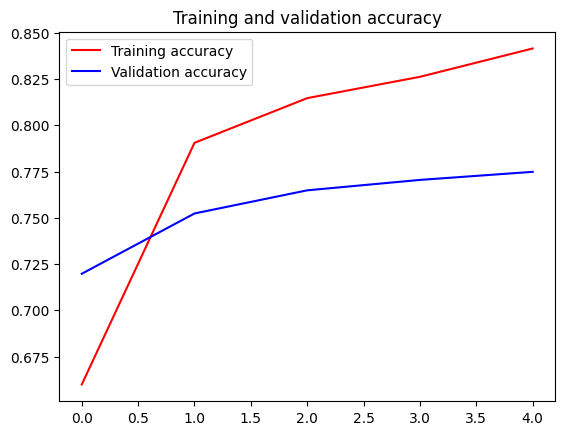

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

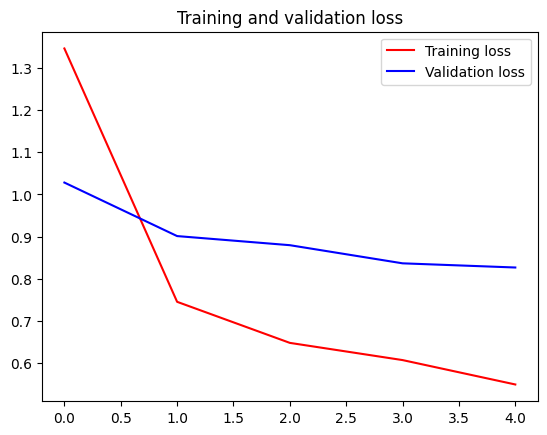

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Printing the metrics of the Inception model tested on test_data
inception_loss,inception_accuracy, inception_precision, inception_recall = Tl_inception_model.evaluate(test_data)
print('Loss on test data: ',inception_loss)
print('Accuracy on test data: ',inception_accuracy)
print('Precision on test data: ',inception_precision)
print('Recall on test data: ',inception_recall)

454/454 [==============================] - 17s 37ms/step - loss: 0.8046 - categorical_accuracy: 0.7944 - precision_9: 0.8339 - recall_9: 0.7669
Loss on test data:  0.804618775844574
Accuracy on test data:  0.7943847179412842
Precision on test data:  0.8339244723320007
Recall on test data:  0.7668811678886414


#### Transfer Learning model 2 VGG model
The VGG (Visual Geometry Group) model is a deep convolutional neural network (CNN) architecture for image classification and object recognition. It was developed by the Visual Geometry Group at the University of Oxford and was introduced in the paper titled "Very Deep Convolutional Networks for Large-Scale Image Recognition" by Simonyan and Zisserman, published in 2014. The VGG model gained popularity for its simplicity and effectiveness in image classification tasks.

In [ ]:
# Using tensorflow to import the VGG19 model with pre-trained weights
vgg_model=tf.keras.applications.VGG19(input_shape=(100,100,3),include_top=False)
vgg_model.trainable = False # this stops model to train the weights on our dataset

In [ ]:
# Taking inputs as 100X100X3 images and passing it through the VGG19 model and passing it to the Dense layer
inputs = layers.Input(shape=(100,100,3))
x = vgg_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Flatten()(x)
outputs = layers.Dense(131,activation="softmax")(x)
Tl_VGG_model = Model(inputs=inputs, outputs=outputs)
Tl_VGG_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 global_average_pooling2d_1   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 flatten_10 (Flatten)        (None, 512)               0         
                                                                 
 dense_20 (Dense)            (None, 131)               67203     
                                                                 
Total params: 20,091,587
Trainable params: 67,203
Non-trainable params: 20,024,384
__________________________________________

In [ ]:
# Compiling the VGG19 model with suitable loss and metrics
Tl_VGG_model.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=Tl_VGG_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
1084/1084 [==============================] - 227s 206ms/step - loss: 3.5268 - categorical_accuracy: 0.3146 - precision_10: 0.9962 - recall_10: 0.0291 - val_loss: 2.8409 - val_categorical_accuracy: 0.4299 - val_precision_10: 0.9944 - val_recall_10: 0.0784
Epoch 2/5
1084/1084 [==============================] - 260s 240ms/step - loss: 2.4124 - categorical_accuracy: 0.5297 - precision_10: 0.9925 - recall_10: 0.1296 - val_loss: 2.2541 - val_categorical_accuracy: 0.5408 - val_precision_10: 0.9918 - val_recall_10: 0.1604
Epoch 3/5
1084/1084 [==============================] - 219s 202ms/step - loss: 1.9569 - categorical_accuracy: 0.6099 - precision_10: 0.9880 - recall_10: 0.2042 - val_loss: 1.9303 - val_categorical_accuracy: 0.5966 - val_precision_10: 0.9859 - val_recall_10: 0.2172
Epoch 4/5
1084/1084 [==============================] - 221s 204ms/step - loss: 1.6858 - categorical_accuracy: 0.6565 - precision_10: 0.9819 - recall_10: 0.2638 - val_loss: 1.7166 - val_categorical_accuracy

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

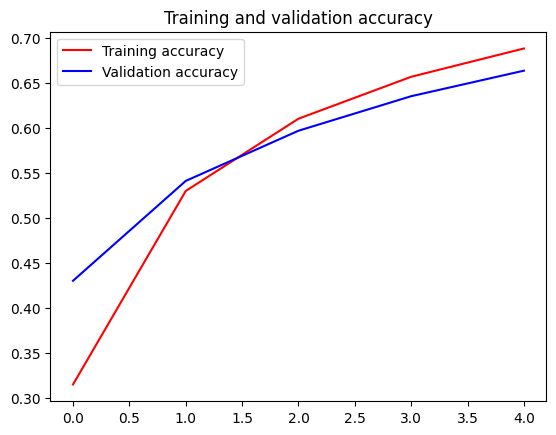

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

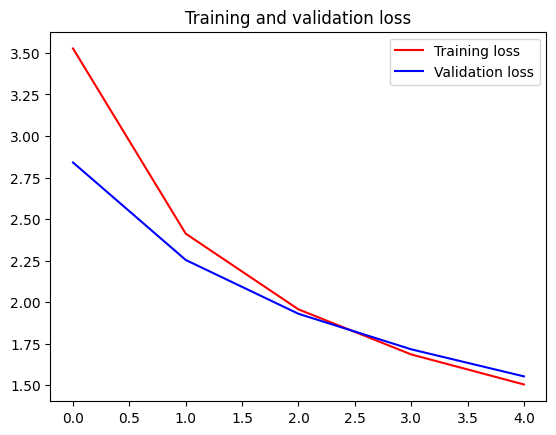

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Printing the metrics of the VGG19 model tested on test_data
Tl_VGG_loss, Tl_VGG_accuracy, Tl_VGG_precision, Tl_VGG_recall = Tl_VGG_model.evaluate(test_data)
print('Loss on test data: ',Tl_VGG_loss)
print('Accuracy on test data: ',Tl_VGG_accuracy)
print('Precision on test data: ',Tl_VGG_precision)
print('Recall on test data: ',Tl_VGG_recall)

454/454 [==============================] - 33s 73ms/step - loss: 1.8081 - categorical_accuracy: 0.5829 - precision_10: 0.9759 - recall_10: 0.2837
Loss on test data:  1.8081496953964233
Accuracy on test data:  0.5828632116317749
Precision on test data:  0.9758908152580261
Recall on test data:  0.2836741805076599


##FINE TUNED TRANSFER LEARNING

### During this part of transfer learning we will use the pre-trained model as well as add few convolutional and dense layers at the end of the pre-trained model so that it can adapt the weights according to our data sets. We will still not train the parameters of the pre-trained model again for our dataset

#### Fine Tuned Inception Model
This model is an tuned version of the InceptionNet on our dataset.  
The last few convolutional layers as well as some dense layers along with some regularization such as Dropout methid

In [ ]:
# Using tensorflow to import inception model along with pre-trained models
inception_model=tf.keras.applications.InceptionV3(input_shape=(100,100,3),include_top=False)
inception_model.trainable=False # this stops model to re-train the weights

In [ ]:
# Taking inputs as 100X100X3 images and passing it through the Inception model
# Adding new convolutional and dense layers to fine tune the model to our data
inputs = layers.Input(shape=(100,100,3))
x = inception_model(inputs)
x = layers.Conv2D(20,1,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(10,activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(131,activation="softmax")(x)
fine_tuned_inception_model = Model(inputs,outputs)
fine_tuned_inception_model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 inception_v3 (Functional)   (None, 1, 1, 2048)        21802784  
                                                                 
 conv2d_197 (Conv2D)         (None, 1, 1, 20)          40980     
                                                                 
 flatten_12 (Flatten)        (None, 20)                0         
                                                                 
 dense_23 (Dense)            (None, 10)                210       
                                                                 
 dropout_1 (Dropout)         (None, 10)                0         
                                                                 
 dense_24 (Dense)            (None, 131)               1441

In [ ]:
# Compiling the fine tuned inception model with suitable loss and metrics
fine_tuned_inception_model.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=fine_tuned_inception_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
1084/1084 [==============================] - 285s 197ms/step - loss: 3.4797 - categorical_accuracy: 0.1717 - precision_12: 0.7426 - recall_12: 0.0213 - val_loss: 2.3703 - val_categorical_accuracy: 0.3605 - val_precision_12: 0.8705 - val_recall_12: 0.0593
Epoch 2/5
1084/1084 [==============================] - 212s 195ms/step - loss: 2.4913 - categorical_accuracy: 0.3280 - precision_12: 0.7437 - recall_12: 0.0915 - val_loss: 1.9507 - val_categorical_accuracy: 0.4551 - val_precision_12: 0.8643 - val_recall_12: 0.1349
Epoch 3/5
1084/1084 [==============================] - 213s 196ms/step - loss: 2.2593 - categorical_accuracy: 0.3767 - precision_12: 0.7567 - recall_12: 0.1395 - val_loss: 1.8002 - val_categorical_accuracy: 0.4939 - val_precision_12: 0.8467 - val_recall_12: 0.1886
Epoch 4/5
1084/1084 [==============================] - 213s 197ms/step - loss: 2.1591 - categorical_accuracy: 0.4007 - precision_12: 0.7603 - recall_12: 0.1731 - val_loss: 1.6889 - val_categorical_accuracy

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

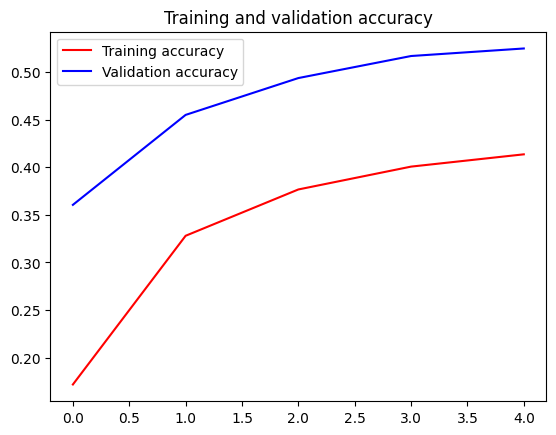

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

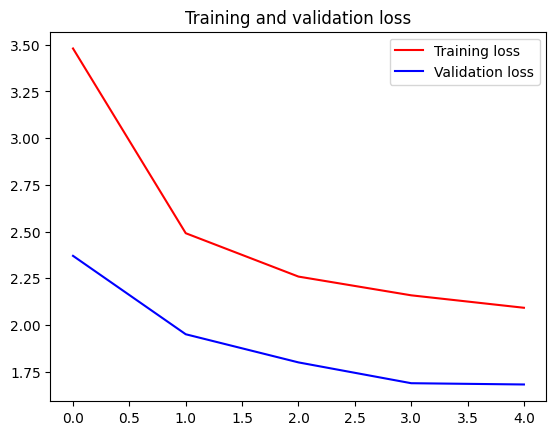

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Printing the metrics of the fine tuned Inception model tested on test_data
fine_tuned_inception_loss, fine_tuned_inception_accuracy, fine_tuned_inception_precision, fine_tuned_inception_recall = fine_tuned_inception_model.evaluate(test_data)
print('Loss on test data: ',fine_tuned_inception_loss)
print('Accuracy on test data: ',fine_tuned_inception_accuracy)
print('Precision on test data: ',fine_tuned_inception_precision)
print('Recall on test data: ',fine_tuned_inception_recall)

454/454 [==============================] - 16s 35ms/step - loss: 1.5649 - categorical_accuracy: 0.5663 - precision_12: 0.8667 - recall_12: 0.2524
Loss on test data:  1.5649464130401611
Accuracy on test data:  0.56633460521698
Precision on test data:  0.8666767477989197
Recall on test data:  0.2524241805076599


#### Fine Tuned VGG19 Model
This model is an tuned version of the VGG19 on our dataset.  
The last few convolutional layers as well as some dense layers along with some regularization such as Dropout methid


In [ ]:
# Using tensorflow to import VGG19 model along with pre-trained models
vgg_model=tf.keras.applications.VGG19(input_shape=(100,100,3),include_top=False)
vgg_model.trainable = False  # this stops model to re-train the weights

In [ ]:
# Taking inputs as 100X100X3 images and passing it through the VGG19 model
# Adding new convolutional and dense layers to fine tune the model to our data
inputs = layers.Input(shape=(100,100,3))
x = vgg_model(inputs)
x = layers.Conv2D(20,1,activation='relu')(x)
x = layers.Flatten()(x)
x = layers.Dense(10,activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(131,activation="softmax")(x)
fine_tuned_VGG_model = Model(inputs=inputs, outputs=outputs)
fine_tuned_VGG_model.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 100, 100, 3)]     0         
                                                                 
 vgg19 (Functional)          (None, 3, 3, 512)         20024384  
                                                                 
 conv2d_198 (Conv2D)         (None, 3, 3, 20)          10260     
                                                                 
 flatten_13 (Flatten)        (None, 180)               0         
                                                                 
 dense_25 (Dense)            (None, 10)                1810      
                                                                 
 dropout_2 (Dropout)         (None, 10)                0         
                                                                 
 dense_26 (Dense)            (None, 131)               1441

In [ ]:
# Compiling the fine tuned VGG19 model with suitable loss and metrics
fine_tuned_VGG_model.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=[CategoricalAccuracy(), Precision(), Recall()])
# Fit the model
history=fine_tuned_VGG_model.fit(
    train_data,
    epochs=5,
    validation_data=val_data
)

Epoch 1/5
1084/1084 [==============================] - 223s 204ms/step - loss: 3.8364 - categorical_accuracy: 0.1257 - precision_13: 0.8365 - recall_13: 0.0177 - val_loss: 2.7119 - val_categorical_accuracy: 0.3009 - val_precision_13: 0.9524 - val_recall_13: 0.0444
Epoch 2/5
1084/1084 [==============================] - 260s 240ms/step - loss: 2.7858 - categorical_accuracy: 0.2771 - precision_13: 0.8256 - recall_13: 0.0654 - val_loss: 2.1979 - val_categorical_accuracy: 0.4035 - val_precision_13: 0.9302 - val_recall_13: 0.0849
Epoch 3/5
1084/1084 [==============================] - 221s 204ms/step - loss: 2.4925 - categorical_accuracy: 0.3409 - precision_13: 0.8271 - recall_13: 0.1037 - val_loss: 1.9675 - val_categorical_accuracy: 0.4565 - val_precision_13: 0.9080 - val_recall_13: 0.1104
Epoch 4/5
1084/1084 [==============================] - 221s 203ms/step - loss: 2.3781 - categorical_accuracy: 0.3635 - precision_13: 0.8160 - recall_13: 0.1261 - val_loss: 1.8347 - val_categorical_accuracy

In [ ]:
acc=history.history['categorical_accuracy']
val_acc=history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

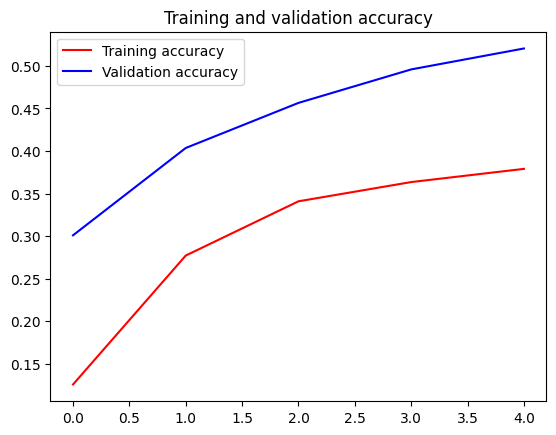

<Figure size 640x480 with 0 Axes>

In [ ]:

# plotting accuracy
epochs = range(len(acc))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

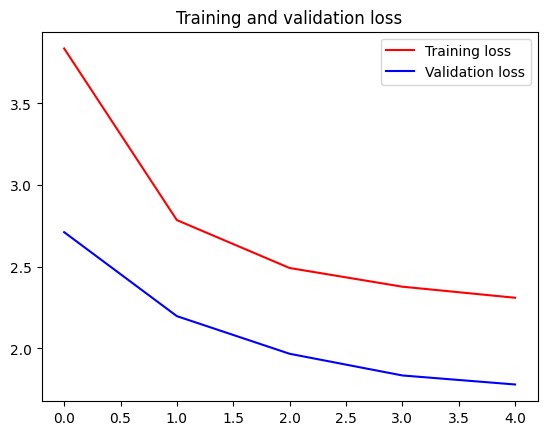

<Figure size 640x480 with 0 Axes>

In [ ]:
# plotting loss
epochs = range(len(acc))
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [ ]:
# Printing the metrics of the fine tuned VGG19 model tested on test_data
fine_tuned_VGG_loss, fine_tuned_VGG_accuracy, fine_tuned_VGG_precision, fine_tuned_VGG_recall = fine_tuned_VGG_model.evaluate(test_data)
print('Loss on test data: ',fine_tuned_VGG_loss)
print('Accuracy on test data: ',fine_tuned_VGG_accuracy)
print('Precision on test data: ',fine_tuned_VGG_precision)
print('Recall on test data: ',fine_tuned_VGG_recall)

454/454 [==============================] - 32s 71ms/step - loss: 1.9669 - categorical_accuracy: 0.4843 - precision_13: 0.8856 - recall_13: 0.1521
Loss on test data:  1.9668771028518677
Accuracy on test data:  0.4842648208141327
Precision on test data:  0.8855530023574829
Recall on test data:  0.15210683643817902


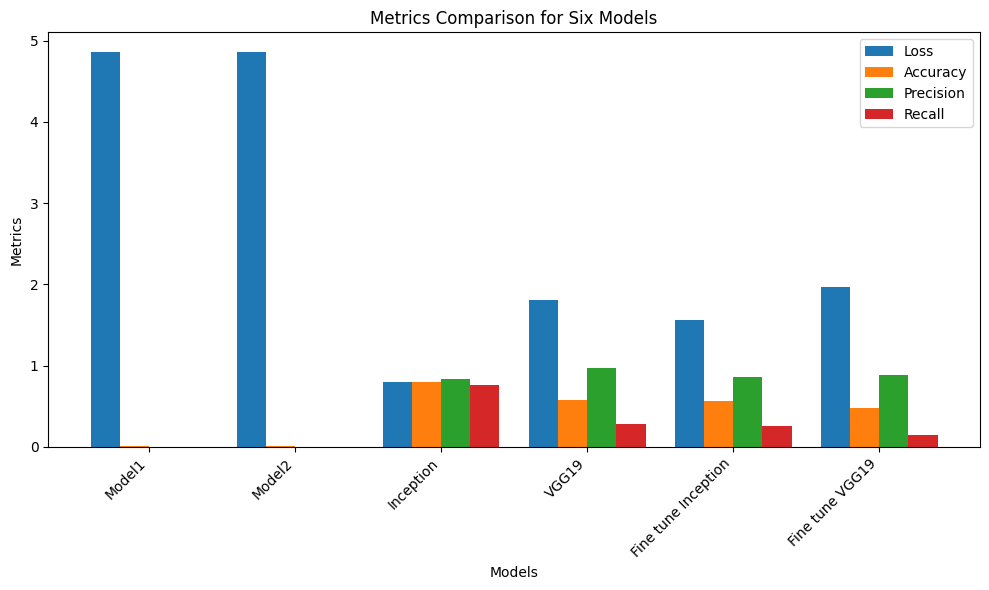

In [5]:

# Model names or labels
model_names = ['Model1', 'Model2', 'Inception', 'VGG19', 'Fine tune Inception', 'Fine tune VGG19']

# Metrics data
loss = [4.8586, 4.8561, 0.8046, 1.8081, 1.5649, 1.9669]
accuracy = [0.0145, 0.0145, 0.7944, 0.5829, 0.5663, 0.4843]
precision = [0.0, 0.0, 0.8339, 0.9759, 0.8667, 0.8856]
recall = [0.0, 0.0, 0.7669, 0.2837, 0.2524, 0.1521]

# Set the width of the bars
bar_width = 0.2

# Set the position of each bar on the x-axis
index = np.arange(len(model_names))

# Create subplots with a larger figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plot each metric as a bar with adjusted positions
bar1 = ax.bar(index - 1.5 * bar_width, loss, bar_width, label='Loss')
bar2 = ax.bar(index - 0.5 * bar_width, accuracy, bar_width, label='Accuracy')
bar3 = ax.bar(index + 0.5 * bar_width, precision, bar_width, label='Precision')
bar4 = ax.bar(index + 1.5 * bar_width, recall, bar_width, label='Recall')

# Set the x-axis labels
ax.set_xticks(index)
ax.set_xticklabels(model_names, rotation=45, ha='right')  # Rotate labels for better readability

# Add labels and title
ax.set_xlabel('Models')
ax.set_ylabel('Metrics')
ax.set_title('Metrics Comparison for Six Models')

# Add legend
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()
